In [ ]:
"""
PROGETTO DI SKETCH CAPTIONING

Questo codice implementa un modello di deep learning per generare descrizioni per sketch.
Il modello utilizza una combinazione di Reti Neurali Convoluzionali (CNN) per l'estrazione delle feature delle immagini
e una LTSM per la generazione del testo.

Il codice esegue i seguenti passaggi principali:
1. Estrazione delle feature delle Immagini: Estrae le feature dalle immagini dei disegni utilizzando un modello CNN pretrained chiamata Xception.
2. Preprocessing del Testo: Pulisce il testo delle descrizioni, fa una lemmatization e fa una tokenizzazione
3. Training del Modello: Definisce e allena un modello utilizzando le feature estratte dalle immagini e i dati di testo preprocessati.
4. Valutazione del Modello: Valuta il modello addestrato utilizzando diverse Score per valutare la qualità delle descrizioni.
5. Generazione di Caption: Genera descrizioni per nuove immagini di disegni utilizzando il modello addestrato.

Autore: Tommaso Senatori
"""

###Import Libraries and Dataset

In [ ]:
import string                    # per operazioni comuni sulle stringhe, ad esempio per rimuovere la punteggiatura dalle didascalie.
import numpy as np               # supporto per l'array multidimensionale e altre operazioni matematiche, fondamentali per il trattamento dei dati.
from PIL import Image            # per aprire, manipolare e salvare immagini, che sono dati di input per il modello di captioning.
import os                        # per interagire con il sistema operativo, ad esempio per gestire i file.
import pickle #(dump e load)     # per la serializzazione e deserializzazione di oggetti Python, utile per salvare e caricare i modelli del progetto.
import matplotlib.pyplot as plt  # per grafico loss over epochs
import re

from keras.applications.xception import Xception, preprocess_input # Fornisce un'implementazione pre-addestrata di Xception, un modello CNN spesso utilizzato per l'estrazione delle caratteristiche delle immagini.
from keras.preprocessing.image import load_img, img_to_array       # Fornisce funzioni per caricare un'immagine da file e convertirla in un array NumPy.
from keras.preprocessing.text import Tokenizer                     # per convertire le didascalie delle immagini in sequenze di token per l'addestramento del modello.
from keras.preprocessing.sequence import pad_sequences             # per aggiungere padding alle sequenze di token delle didascalie delle immagini, assicurando che abbiano tutte la stessa lunghezza.
from keras.utils import to_categorical, plot_model                 # per fare ohe e per stampare l'architettura dei modelli
from keras.layers import add                                       # per aggiungere collegamenti residui tra i layer del modello.
from keras.models import Model, load_model                         # Fornisce supporto per la definizione e il caricamento dei modelli di deep learning.
from keras.layers import Input, Dense, LSTM, Embedding, Dropout    # Fornisce le classi necessarie per definire gli strati del modello di captioning, come strati di input, LSTM, Embedding, Dropout, ecc.
from keras.optimizers import Adam

from tqdm.notebook import tqdm # for seeing the progress of loops
tqdm().pandas()

0it [00:00, ?it/s]

In [ ]:
BASE_DIR = "/content/drive/MyDrive/Tirocinio/Datasets/zoheb_sketch-scene"
WORKING_DIR = "/content/drive/MyDrive/Tirocinio/sketch"

dataset_text = os.path.join(BASE_DIR, 'captions.txt')
dataset_images = os.path.join(BASE_DIR, 'Images')

###Feature Extraction

83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

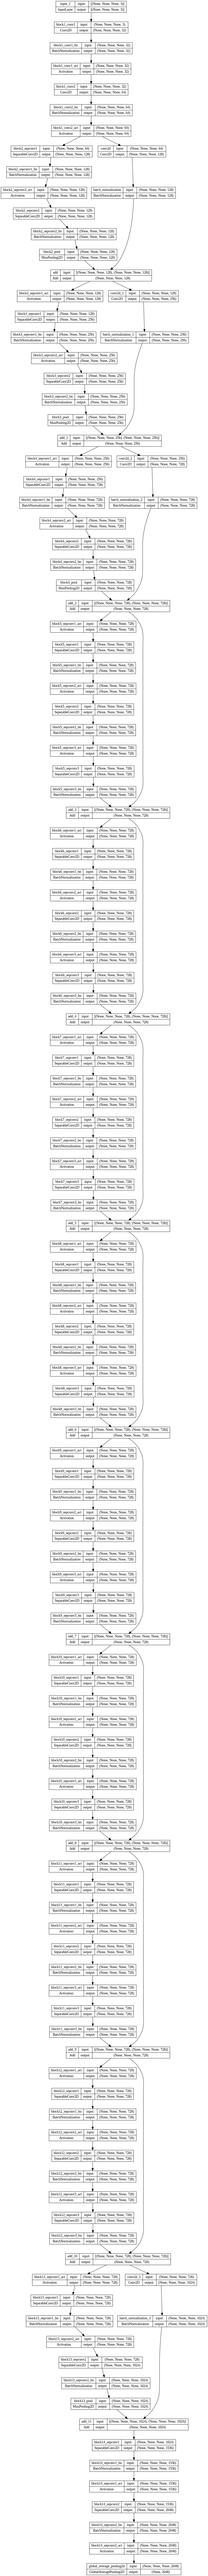

In [ ]:
model = Xception(include_top=False, pooling='avg')
print(model.summary())
# plot model
plot_model(model, show_shapes=True)

#  "None, None, None" shape = layer is capable of processing inputs of variable spatial dimensions.

1/1 [==============================] - 1s 1s/step
Shape of extracted features: (1, 2048)


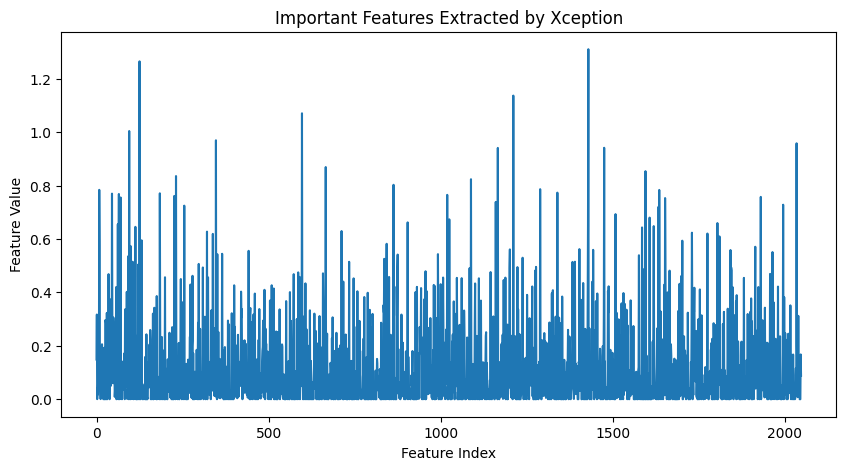

In [ ]:
img_path = dataset_images + "/img0.jpg"
image = Image.open(img_path).convert('RGB')
image = image.resize((299, 299))

image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

features = model.predict(image)

print("Shape of extracted features:", features.shape)

# Plotto le features più importanti
plt.figure(figsize=(10, 5))
plt.plot(features.ravel())
plt.title('Important Features Extracted by Xception')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()

In [ ]:
# feature extraction dalle immagini: creo un dictionary (key,value) = (image_id,features)
def extract_features(directory):
        features = {}
        for img_name in tqdm(os.listdir(directory)):
            # load image from file
            img_path = directory + "/" + img_name
            image = Image.open(img_path).convert('RGB')  # Convert to RGB
            # reshape data for model
            image = image.resize((299, 299))
            image = np.expand_dims(image, axis=0)
            # preprocess image for Xception
            image = preprocess_input(image)
            # estraggo le features
            feature = model.predict(image, verbose=0)
            image_id = img_name.split('.')[0] # image_id = image name without .jpg
            features[img_name] = feature
        return features

# eseguo
features = extract_features(dataset_images)

In [ ]:
# save features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features_sketch.pkl'), 'wb'))

In [ ]:
# load features from pickle
features = pickle.load(open(os.path.join(WORKING_DIR, 'features_sketch.pkl'),"rb"))

###Load captions data

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r', encoding='latin-1') as f:
    next(f)  # skip first line
    captions_doc = f.read()


In [ ]:
def create_mapping(filename, encoding='utf-8', errors='ignore'):
    mapping = {}
    with open(filename, 'r', encoding=encoding, errors=errors) as file:
        next(file)  # skip header line
        for line in file:
            parts = line.strip().split(',')
            img_id = parts[0].split('.')[0]  # Remove the file extension
            caption = ','.join(parts[1:])  # Join all but the first part
            mapping[img_id] = caption
    return mapping

In [ ]:
# eseguo
mapping = create_mapping(dataset_text)
print("Number of unique images =" ,len(mapping))

Number of unique images = 9999


###Preprocess text data

In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')   # modelli per la tokenization
nltk.download('wordnet') # database inglese che dà correlazioni semantiche tra parole

def clean(mapping):
    clean_mapping = {} # creo un nuovo dictionary per metterci le caption pulite
    lemmatizer = WordNetLemmatizer()  # Inizializzo il lemmatizer
    for key, caption in mapping.items(): # per ogni image_id e la sua caption
        caption = caption.lower() # lowercase
        caption = re.sub(r'[^\w\s]', '', caption) # rimuovo caratteri non alfanumerici (\w) o spazi (\s)
        caption = re.sub(r'\s+', ' ', caption) # rimpiazzo spazi consecutivi con uno solo

        # tokenizzo la caption in parole (token)
        tokens = word_tokenize(caption)
        # Lemmatizzazione dei token: ogni token è rimpiazzato con il suo lemma (forma base)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        # Rimetto il caption pulito in una stringa
        cleaned_caption = ' '.join(lemmatized_tokens)
        # Aggiungo i tag di inizio e fine
        cleaned_caption = 'startseq ' + cleaned_caption + ' endseq'
        # Rimpiazzo la caption originale con quella pulita
        clean_mapping[key] = [cleaned_caption]
    return clean_mapping

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# before preprocess of text
print(mapping['img0'])
print(mapping['img1'])
print(mapping['img2'])
print(mapping['img5'])
print(mapping['img6'])

giraffe is eating leaves from the tree
A zebra is eating grass
people are riding on the  horses
Some birds are sitting on a branch of a tree
People gathered over a park


In [ ]:
# cleaning text
mapping = clean(mapping)
# after preprocess of text
print(mapping['img0'])
print(mapping['img1'])
print(mapping['img2'])
print(mapping['img5'])
print(mapping['img6'])

['startseq giraffe is eating leaf from the tree endseq']
['startseq a zebra is eating grass endseq']
['startseq people are riding on the horse endseq']
['startseq some bird are sitting on a branch of a tree endseq']
['startseq people gathered over a park endseq']


In [ ]:
# from mapping (dict) to all_captions (list)
def extract_all_captions(mapping):
    all_captions = []
    for captions_list in mapping.values():
        for caption in captions_list:
            all_captions.append(caption)
    return all_captions

# eseguo
all_captions = extract_all_captions(mapping)

In [ ]:
len(all_captions)

9999

In [ ]:
all_captions[:10]

['startseq giraffe is eating leaf from the tree endseq',
 'startseq a zebra is eating grass endseq',
 'startseq people are riding on the horse endseq',
 'startseq two girafees eating the tree leaf endseq',
 'startseq an areoplane airfranceis flying endseq',
 'startseq some bird are sitting on a branch of a tree endseq',
 'startseq people gathered over a park endseq',
 'startseq stop board in the park endseq',
 'startseq zeebras walking in the grass endseq',
 'startseq people moving on the road endseq']

In [ ]:
# tokenize text (create vocabulary, assigning an index per each word)
def tokenization(all_captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_captions)
    return tokenizer

# eseguo
tokenizer = tokenization(all_captions)
vocab_size = len(tokenizer.word_index) + 1 # tot number of unique words
print(vocab_size)

2122


In [ ]:
tokenizer.word_index # the lower the integer assigned to a word, the more the frequency in the captions

{'startseq': 1,
 'endseq': 2,
 'a': 3,
 'the': 4,
 'in': 5,
 'on': 6,
 'is': 7,
 'with': 8,
 'flying': 9,
 'are': 10,
 'standing': 11,
 'of': 12,
 'and': 13,
 'playing': 14,
 'grass': 15,
 'man': 16,
 'sky': 17,
 'two': 18,
 'giraffe': 19,
 'an': 20,
 'tree': 21,
 'road': 22,
 'near': 23,
 'kite': 24,
 'people': 25,
 'field': 26,
 'board': 27,
 'zebra': 28,
 'sitting': 29,
 'boy': 30,
 'ground': 31,
 'horse': 32,
 'sign': 33,
 'plane': 34,
 'clock': 35,
 'cow': 36,
 'eating': 37,
 'dog': 38,
 'sheep': 39,
 'to': 40,
 'pole': 41,
 'park': 42,
 'train': 43,
 'bird': 44,
 'walking': 45,
 'forest': 46,
 'person': 47,
 'girl': 48,
 'elephant': 49,
 'traffic': 50,
 'tower': 51,
 'at': 52,
 'disc': 53,
 'aeroplane': 54,
 'garden': 55,
 'building': 56,
 'holding': 57,
 'grazing': 58,
 'street': 59,
 'side': 60,
 'bench': 61,
 'it': 62,
 'frisbee': 63,
 'jungle': 64,
 'beside': 65,
 'animal': 66,
 'signal': 67,
 'some': 68,
 'open': 69,
 'airplane': 70,
 'stop': 71,
 'car': 72,
 'water': 73,
 '

In [ ]:
# get maximum length of the caption available (to do padding)
max_length = max(len(caption.split()) for caption in all_captions)
max_length

32

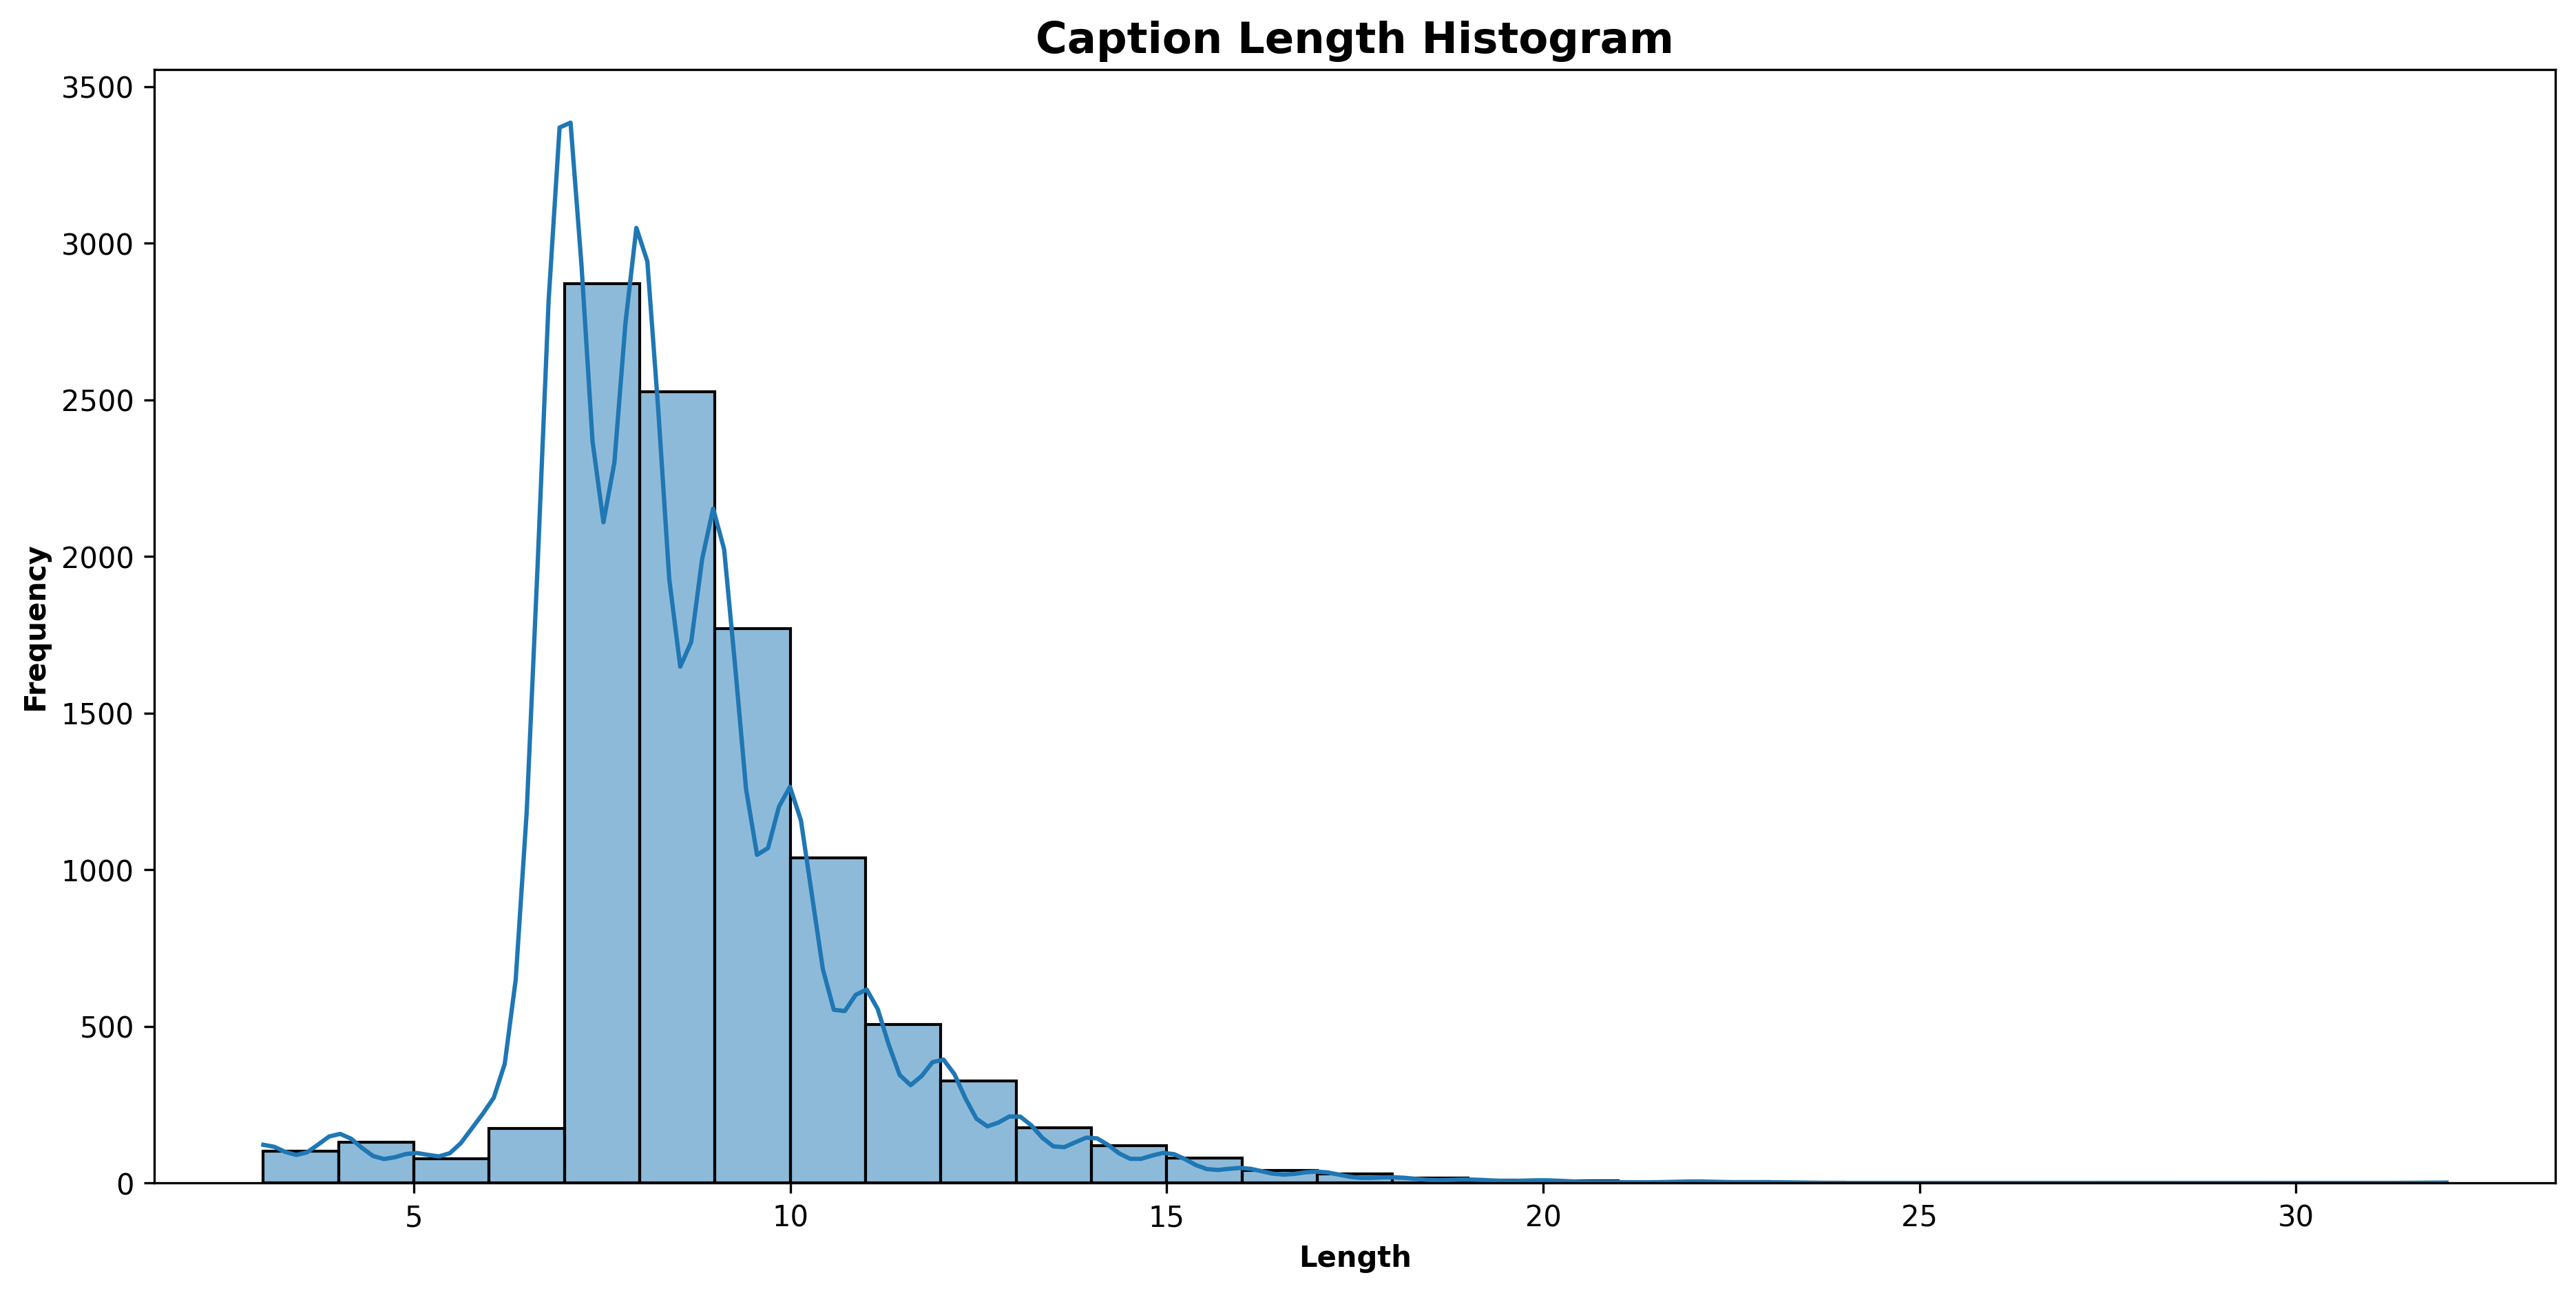

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_caption_lengths(captions):
    # dimensione e risoluzione
    plt.figure(figsize=(15, 7), dpi=300) # dotsperinch (resolution)

    # lista con length per ogni caption
    caption_lengths = [len(caption.split()) for caption in captions]

    # plot istogramma
    sns.histplot(x=caption_lengths, kde=True, binwidth=1)

    # Set plot titles and labels
    plt.title('Caption Length Histogram', fontsize=15, fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Frequency', fontweight='bold')

    # Show the plot
    plt.show()

# eseguo
plot_caption_lengths(all_captions)

###Train Test Split

In [ ]:
image_ids = list(mapping.keys())

split = int(len(image_ids) * 0.80)
train = image_ids[:split]
remaining = image_ids[split:]

# Divido le immagini restanti (2000) a metà: 1000 per il validation set e 1000 per il test set
split2 = len(remaining) // 2
val = remaining[:split2]
test = remaining[split2:]

# Verify the sizes of the splits
print("Train set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

Train set size: 7999
Validation set size: 1000
Test set size: 1000


In [ ]:
# creo data generator per dividire i dati in batch (evita il session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list() #((454, 2048), (454, 32), (454, 2122))
    n = 0
    while 1:
        for key in data_keys: # for each image_id
            n+=1
            captions = mapping[key]
            # processo ogni caption
            for caption in captions: # per ogni caption con lo stesso image_id
                # encode the sequence: we get an index for each word
                seq = tokenizer.texts_to_sequences([caption])[0]
                # splitto la sequenza in coppie X,y
                for i in range(1, len(seq)):
                    # split into input and output paths
                    in_seq, out_seq = seq[:i], seq[i]
                    # padding of input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # one hot encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size: # reset per evitare un crash
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
# You can check the shape of the input and output for your model

gen = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size=64)

# Get a batch of data from the generator
X, y = next(gen)

# Print the shape of X1, X2, and y
X1, X2 = X
print("Shape of X1:", X1.shape)
print("Shape of X2:", X2.shape)
print("Shape of y:", y.shape)

Shape of X1: (454, 2048)
Shape of X2: (454, 32)
Shape of y: (454, 2122)


###Model Creation

In [ ]:
# define the captioning model
def define_model(vocab_size, max_length, alpha):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,)) # input: Xception output (2048)
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=alpha))

    return model

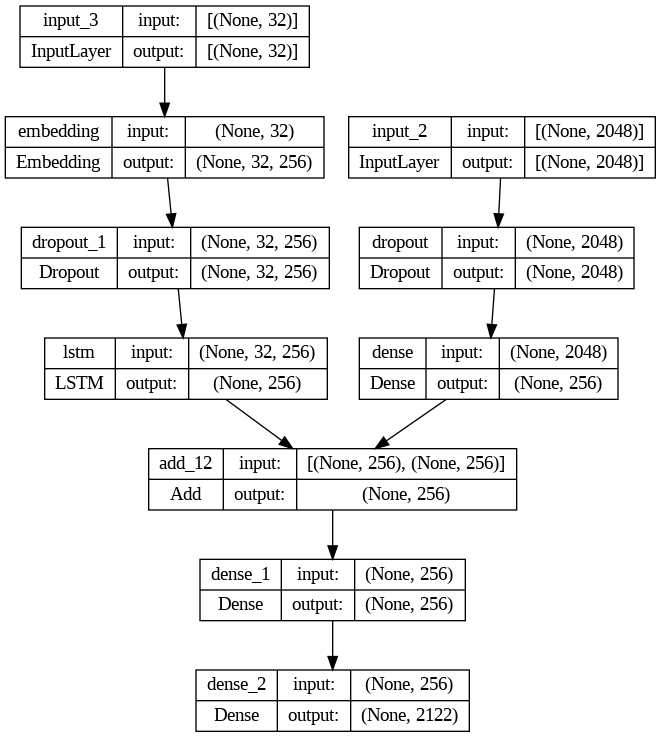

In [ ]:
model = define_model(vocab_size, max_length, alpha=0.001)
plot_model(model, show_shapes=True)

###Train the model

In [ ]:
losses = []
val_losses = []
epochs = 15
batch_size = 64
steps = len(train) // batch_size
val_steps = len(val) // batch_size

for i in range(epochs):
    # Create data generator for training set
    train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # Create data generator for validation set
    val_generator = data_generator(val, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    # Fit the model for 1 epoch
    history = model.fit(train_generator, epochs=1, steps_per_epoch=steps, validation_data=val_generator,
                        validation_steps=val_steps, verbose=1)

    # Store the losses for this epoch
    losses.append(history.history['loss'][0])
    val_losses.append(history.history['val_loss'][0])

    # Save the model at the 6th epoch
    if i == 5: model.save(WORKING_DIR + '/MODEL_6SKETCH.h5')


124/124 [==============================] - 13s 107ms/step - loss: 1.6182 - val_loss: 3.0917


In [ ]:
# Save losses
with open(os.path.join(WORKING_DIR, 'losses_15sketch.pkl'), 'wb') as f:
    pickle.dump(losses, f)
with open(os.path.join(WORKING_DIR, 'vlosses_15sketch.pkl'), 'wb') as f:
    pickle.dump(val_losses, f)

In [ ]:
# Load losses
with open(os.path.join(WORKING_DIR, 'losses_15sketch.pkl'), 'rb') as f:
    losses = pickle.load(f)
with open(os.path.join(WORKING_DIR, 'vlosses_15sketch.pkl'), 'rb') as f:
    val_losses = pickle.load(f)

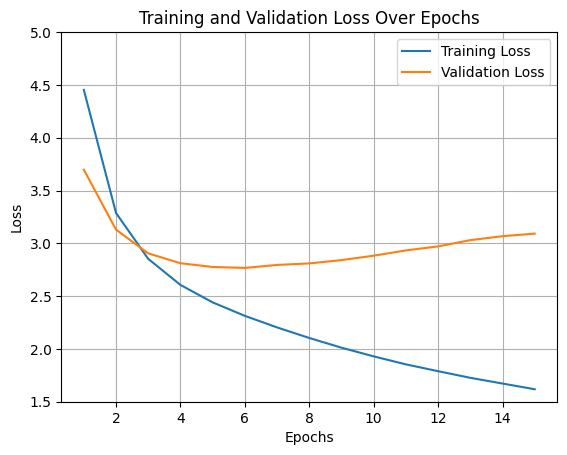

In [ ]:
def plot_loss(losses, val_losses):
    epochs = len(losses)
    plt.plot(range(1, epochs + 1), losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.ylim(1.5, 5.0)
    plt.show()

plot_loss(losses, val_losses)


In [ ]:
# save the model
model.save(WORKING_DIR + '/MODEL_6SKETCH.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# load the model
model = load_model(WORKING_DIR + '/MODEL_6SKETCH.h5')

###Generate captions for the image

In [ ]:
def idx_to_word(integer, tokenizer): # rida la parola a cui corrisponde l'integer
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generazione della caption per un'immagine (greedy)
def predict_caption_greedy(model, image_features, tokenizer, max_length):
    # aggiungo lo start tag
    in_text = 'startseq'
    # per ogni parola (caption non più lunga di max_length)
    for i in range(max_length):
        # encode input sequence (convert words to integers)
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict the next word
        yhat = model.predict([image_features, sequence], verbose=0)
        # get index with highest probability
        yhat = np.argmax(yhat)
        # convert predicted index to a word
        word = idx_to_word(yhat, tokenizer)
        # stop if word is not found
        if word is None: break
        # else : append word as input for generating next word
        in_text += " " + word
        # stop se raggiungiamo l'end tag
        if word == 'endseq': break
    return in_text

In [ ]:
# generazione della caption per un'immagine (beam search)
def predict_caption_beam_search(model, image_features, tokenizer, max_length, beam_width):
    # Inizializzazione
    start_seq = 'startseq'
    sequences = [(start_seq, 0.0)] # (word, LogLikelihood)

    # Beam search loop
    while len(sequences[0][0].split()) < max_length:
        all_candidates = []
        # iteriamo per ogni elemento in ogni sequenza
        for seq, score in sequences:
            # Encode input sequence
            encoded_seq = tokenizer.texts_to_sequences([seq])[0]
            # pad the sequence
            encoded_seq = pad_sequences([encoded_seq], maxlen=max_length, padding='post')
            # get probabilities of every word to be the next
            yhat = model.predict([image_features, encoded_seq], verbose=0)
            # Get top "beam_width" candidates
            top_candidates = np.argsort(yhat[0])[-beam_width:] # [-x:] : gli ultimi 3 (i più alti)
            # per ogni candidate, creo una nuova sequenza
            for word_idx in top_candidates:
                candidate_seq = seq + " " + idx_to_word(word_idx, tokenizer)   # aggiungo la parola alla sequenza
                candidate_score = score + np.log(yhat[0][word_idx])
                all_candidates.append((candidate_seq, candidate_score)) # calcolo la score della parola
        # ordino tutti i candidates in base al loro 2o elemento (score)
        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
        # seleziono i primi "beam_width" candidates
        sequences = ordered[:beam_width]
        # stop se raggiungiamo l'end tag
        if sequences[0][0].split()[-1] == 'endseq': break

    # return best sequence
    return sequences[0][0]

beam_width = 5

###Calculate BLEU Score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# Calcola le score BLEU-1 e BLEU-2 per l'intero test set, usando il metodo di predizione greedy
def calculate_bleu_score_greedy(model, test, mapping, features, tokenizer, max_length):
    actual, predicted = list(), list()

    for key in tqdm(test):  # for each image_id in test set
        # get actual caption
        captions = mapping[key]
        # predict the entire caption for image
        y_pred = predict_caption_greedy(model, features[key], tokenizer, max_length)
        # split into words
        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()
        # append to the lists
        actual.append(actual_captions)
        predicted.append(y_pred)

    # calculate BLEU score (score for text data) (excellent if >0.4)
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

    return bleu1, bleu2


# Calcola le score BLEU-1 e BLEU-2 per l'intero test set, usando il metodo di predizione beam search
def calculate_bleu_score_beam_search(model, test, mapping, features, tokenizer, max_length):
    actual, predicted = list(), list()

    for key in tqdm(test):  # for each image_id in test set
        # get actual caption
        captions = mapping[key]
        # predict the entire caption for image
        y_pred = predict_caption_beam_search(model, features[key], tokenizer, max_length, beam_width)
        # split into words
        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()
        # append to the lists
        actual.append(actual_captions)
        predicted.append(y_pred)

    # calculate BLEU score (score for text data) (excellent if >0.4)
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

    return bleu1, bleu2


# eseguo

bleu1_greedy, bleu2_greedy = calculate_bleu_score_greedy(model, test, mapping, features, tokenizer, max_length)
print("BLEU-1 (greedy): {:.6f}".format(bleu1_greedy))
print("BLEU-2 (greedy): {:.6f}".format(bleu2_greedy))

bleu1_beam, bleu2_beam = calculate_bleu_score_beam_search(model, test, mapping, features, tokenizer, max_length)
print("BLEU-1 (beam search): {:.6f}".format(bleu1_beam))t
print("BLEU-2 (beam search): {:.6f}".format(bleu2_beam))

  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-1 (greedy): 0.445831
BLEU-2 (greedy): 0.247458


  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-1 (beam search): 0.441479
BLEU-2 (beam search): 0.246538


In [ ]:
# SEGNATI LE SCORE
# epochs = 7 ---> 3.0979, 0.429682, 0.211213
# epochs = 7 ---> 2.7962, 0.439372, 0.244966 (LEMMATIZATION)
# epochs = 6 ---> 2.7670, 0.445831, 0.247458 (LEMMATIZATION)
# epochs = 6 ---> 2.7670, 0.441479, 0.246538 (beam search)

###Calculate CIDEr Score

In [ ]:
from pycocoevalcap.cider.cider import Cider

# Calcola la score CIDEr per l'intero test set, usando il metodo di predizione greedy
def calculate_cider_score_greedy(model, test, mapping, features, tokenizer, max_length):
    actual, predicted = {}, {} # devono per forza essere mappe, perchè sono i parametri di compute_score

    for key in tqdm(test):  # for each image_id in test set
        # get actual caption
        captions = mapping[key]
        # predict the entire caption for image
        y_pred = predict_caption_greedy(model, features[key], tokenizer, max_length)
        # append to the dictionaries
        actual[key] = [' '.join(caption.split()) for caption in captions]
        predicted[key] = [' '.join(y_pred.split())]

    # calculate CIDEr score
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(actual, predicted)

    return cider_score


# Calcola la score CIDEr per l'intero test set, usando il metodo di predizione beam search
def calculate_cider_score_beam_search(model, test, mapping, features, tokenizer, max_length):
    actual, predicted = {}, {} # devono per forza essere mappe, perchè sono i parametri di compute_score

    for key in tqdm(test):  # for each image_id in test set
        # get actual caption
        captions = mapping[key]
        # predict the entire caption for image
        y_pred = predict_caption_beam_search(model, features[key], tokenizer, max_length, beam_width)
        # append to the dictionaries
        actual[key] = [' '.join(caption.split()) for caption in captions]
        predicted[key] = [' '.join(y_pred.split())]

    # calculate CIDEr score
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(actual, predicted)

    return cider_score


# eseguo

cider_score_greedy = calculate_cider_score_greedy(model, test, mapping, features, tokenizer, max_length)
print("CIDEr (greedy): {:.6f}".format(cider_score_greedy))

cider_score_beam_search = calculate_cider_score_beam_search(model, test, mapping, features, tokenizer, max_length)
print("CIDEr (beam search): {:.6f}".format(cider_score_beam_search))

  0%|          | 0/1000 [00:00<?, ?it/s]

CIDEr (greedy): 0.643714


  0%|          | 0/1000 [00:00<?, ?it/s]

CIDEr (beam search): 0.682530


###Calculate ROUGE-L Score

In [ ]:
from rouge import Rouge

# Calcola le score BLEU-1 e BLEU-2 per l'intero test set, usando il metodo di predizione greedy
def calculate_rougel_score_greedy(model, test, mapping, features, tokenizer, max_length):
    actual, predicted = list(), list()

    for key in tqdm(test):  # for each image_id in test set
        # get actual caption
        captions = mapping[key]
        # predict the entire caption for image
        y_pred = predict_caption_greedy(model, features[key], tokenizer, max_length)
        # append to the lists
        actual.append(captions[0])
        predicted.append(y_pred)

    # calculate ROUGE-L score
    rouge = Rouge()
    scores = rouge.get_scores(predicted, actual, avg=True)
    rouge_l_score = scores["rouge-l"]["f"] #ROUGE-L, F1-score

    return rouge_l_score


# Calcola le score BLEU-1 e BLEU-2 per l'intero test set, usando il metodo di predizione beam search
def calculate_rougel_score_beam_search(model, test, mapping, features, tokenizer, max_length):
    actual, predicted = list(), list()

    for key in tqdm(test):  # for each image_id in test set
        # get actual caption
        captions = mapping[key]
        # predict the entire caption for image
        y_pred = predict_caption_beam_search(model, features[key], tokenizer, max_length, beam_width)
        # append to the lists
        actual.append(captions[0])
        predicted.append(y_pred)

    # calculate ROUGE-L score
    rouge = Rouge()
    scores = rouge.get_scores(predicted, actual, avg=True)
    rouge_l_score = scores["rouge-l"]["f"] #ROUGE-L, F1-score

    return rouge_l_score


# eseguo

rougel_greedy = calculate_rougel_score_greedy(model, test, mapping, features, tokenizer, max_length)
print("ROUGE-L (greedy): {:.6f}".format(rougel_greedy))
rougel_beam_search = calculate_rougel_score_beam_search(model, test, mapping, features, tokenizer, max_length)
print("ROUGE-L (beam search): {:.6f}".format(rougel_beam_search))

  0%|          | 0/1000 [00:00<?, ?it/s]

ROUGE-L (greedy): 0.453774


  0%|          | 0/1000 [00:00<?, ?it/s]

ROUGE-L (beam search): 0.458480


###Visualize the results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)

    print('---------------------Actual---------------------')
    caption = mapping[image_id]
    print(caption)

    print('---------------------Predicted (Greedy)---------------------')
    y_pred_greedy = predict_caption_greedy(model, features[image_id], tokenizer, max_length)
    print(y_pred_greedy)

    print('---------------------Predicted (Beam Search)---------------------')
    y_pred_beam_search = predict_caption_beam_search(model, features[image_id], tokenizer, max_length, beam_width)
    print(y_pred_beam_search)

    plt.imshow(image, cmap='gray') # sfondo bianco


####Training Images

---------------------Actual---------------------
['startseq giraffe is eating leaf from the tree endseq']
---------------------Predicted (Greedy)---------------------
startseq a giraffe in the forest endseq
---------------------Predicted (Beam Search)---------------------
startseq a giraffe in the forest endseq


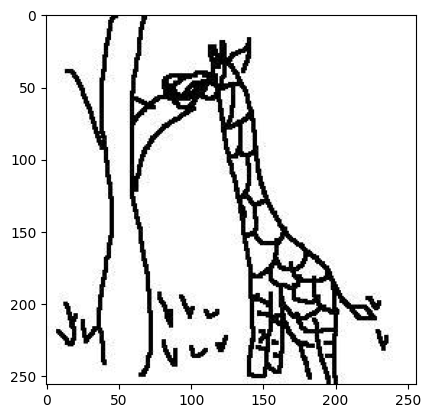

In [ ]:
generate_caption("img0.jpg") #ok

---------------------Actual---------------------
['startseq a zebra is eating grass endseq']
---------------------Predicted (Greedy)---------------------
startseq a zebra is eating grass endseq
---------------------Predicted (Beam Search)---------------------
startseq a zebra is eating grass endseq


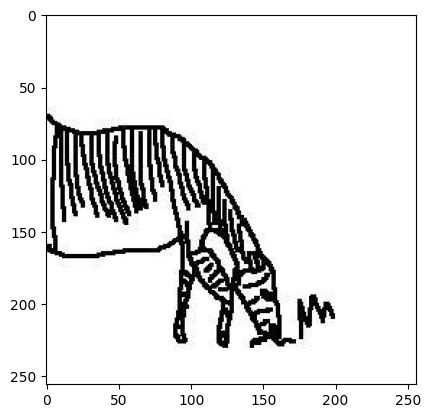

In [ ]:
generate_caption("img1.jpg") #ok

---------------------Actual---------------------
['startseq an areoplane airfranceis flying endseq']
---------------------Predicted (Greedy)---------------------
startseq an aero plane is flying in the sky endseq
---------------------Predicted (Beam Search)---------------------
startseq an aero plane is flying in the sky endseq


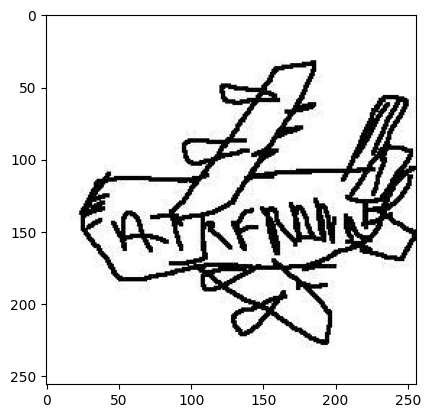

In [ ]:
generate_caption("img4.jpg") #ok

---------------------Actual---------------------
['startseq a train on the track endseq']
---------------------Predicted (Greedy)---------------------
startseq a train moving on track endseq
---------------------Predicted (Beam Search)---------------------
startseq a train moving on track endseq


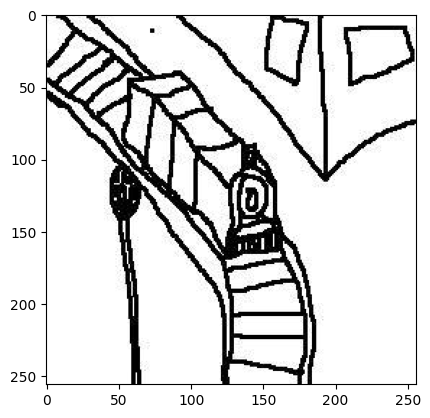

In [ ]:
generate_caption("img165.jpg") #ok

---------------------Actual---------------------
['startseq stop sign at the road side endseq']
---------------------Predicted (Greedy)---------------------
startseq a stop sign board on the road endseq
---------------------Predicted (Beam Search)---------------------
startseq direction board on the road endseq


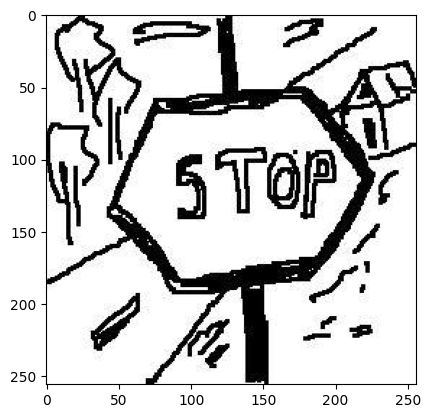

In [ ]:
generate_caption("img1527.jpg") #greedy

---------------------Actual---------------------
['startseq a train moving on track endseq']
---------------------Predicted (Greedy)---------------------
startseq a train moving on track endseq
---------------------Predicted (Beam Search)---------------------
startseq a train moving on track endseq


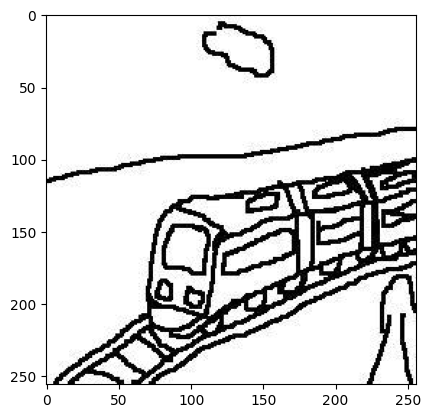

In [ ]:
generate_caption("img1664.jpg") #ok

---------------------Actual---------------------
['startseq an aeroplane flying high in the sky endseq']
---------------------Predicted (Greedy)---------------------
startseq an aeroplane is flying in the sky endseq
---------------------Predicted (Beam Search)---------------------
startseq an areoplane is flying in the sky endseq


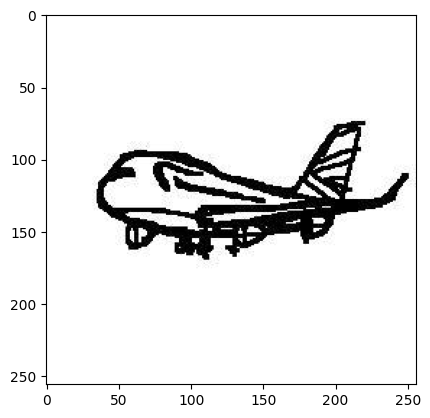

In [ ]:
generate_caption("img2208.jpg") #ok

---------------------Actual---------------------
['startseq a huge cathedral showing time endseq']
---------------------Predicted (Greedy)---------------------
startseq a clock tower on the top of a building endseq
---------------------Predicted (Beam Search)---------------------
startseq a tower with a clock endseq


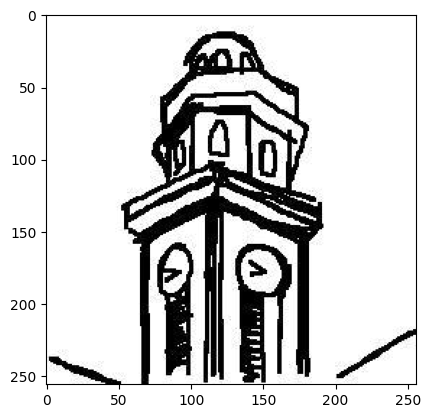

In [ ]:
generate_caption("img2274.jpg") #beam

---------------------Actual---------------------
['startseq a kid playing with a flying disc endseq']
---------------------Predicted (Greedy)---------------------
startseq a man playing with a flying disc endseq
---------------------Predicted (Beam Search)---------------------
startseq a girl playing with a flying disc endseq


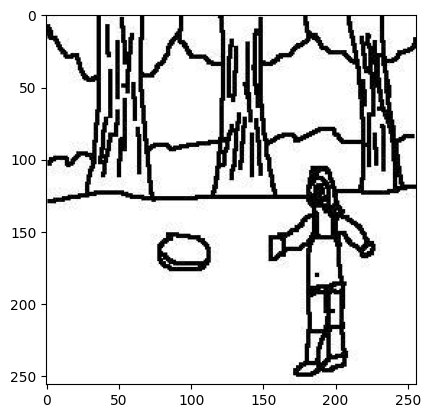

In [ ]:
generate_caption("img3584.jpg") #ok

---------------------Actual---------------------
['startseq a train moving on the track endseq']
---------------------Predicted (Greedy)---------------------
startseq a train moving on track endseq
---------------------Predicted (Beam Search)---------------------
startseq a train moving on track endseq


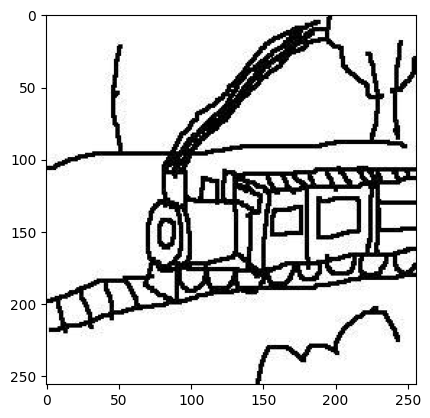

In [ ]:
generate_caption("img4386.jpg") #ok

---------------------Actual---------------------
['startseq tower with clock on it endseq']
---------------------Predicted (Greedy)---------------------
startseq a clock tower with a clock tower endseq
---------------------Predicted (Beam Search)---------------------
startseq a clock tower showing time endseq


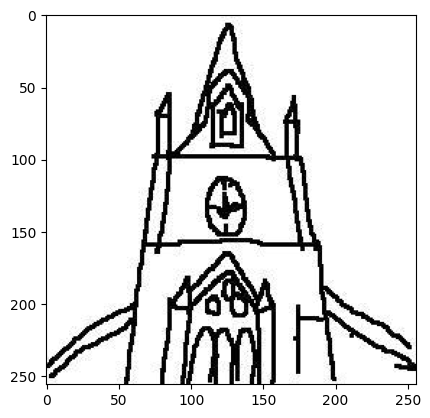

In [ ]:
generate_caption("img6664.jpg") #beam

---------------------Actual---------------------
['startseq two sheep are eating grass endseq']
---------------------Predicted (Greedy)---------------------
startseq a dog is playing with a ring endseq
---------------------Predicted (Beam Search)---------------------
startseq a dog is playing with a ring endseq


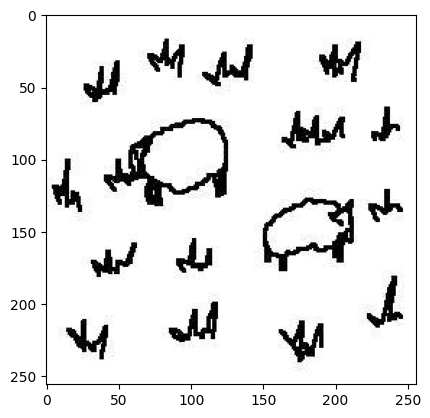

In [ ]:
generate_caption("img6666.jpg") #NO

####Test Images

---------------------Actual---------------------
['startseq a zebra standing in a field endseq']
---------------------Predicted (Greedy)---------------------
startseq a zebra in the forest endseq
---------------------Predicted (Beam Search)---------------------
startseq a zebra in the forest endseq


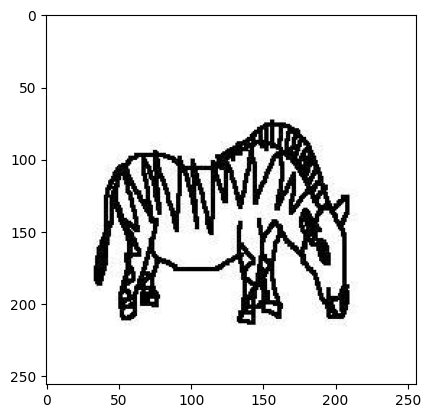

In [ ]:
generate_caption("img9989.jpg") #ok

---------------------Actual---------------------
['startseq a clock at the top of a house endseq']
---------------------Predicted (Greedy)---------------------
startseq a clock tower on a road endseq
---------------------Predicted (Beam Search)---------------------
startseq a tower with a clock endseq


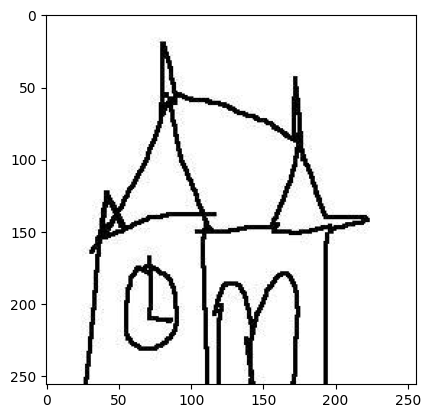

In [ ]:
generate_caption("img9958.jpg") #ok

---------------------Actual---------------------
['startseq airplane endseq']
---------------------Predicted (Greedy)---------------------
startseq an aeroplane is flying in the sky endseq
---------------------Predicted (Beam Search)---------------------
startseq an aero plane is flying in the sky endseq


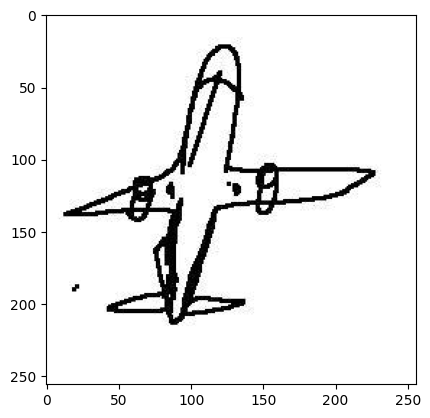

In [ ]:
generate_caption("img9114.jpg") #ok

---------------------Actual---------------------
['startseq a bird sitting on a branch endseq']
---------------------Predicted (Greedy)---------------------
startseq a bird sitting on the branch of tree endseq
---------------------Predicted (Beam Search)---------------------
startseq a bird sitting on a tree branch endseq


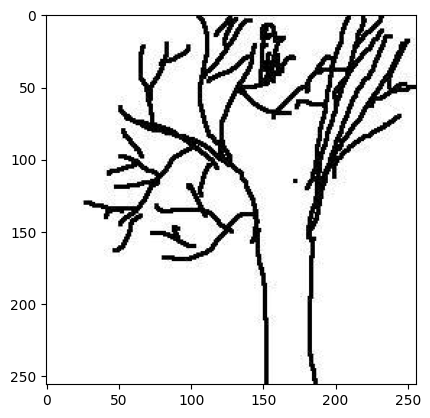

In [ ]:
generate_caption("img8946.jpg") #ok

---------------------Actual---------------------
['startseq a giraffe eating leaf from a tree endseq']
---------------------Predicted (Greedy)---------------------
startseq a giraffe standing in the forest endseq
---------------------Predicted (Beam Search)---------------------
startseq giraffe standing near the tree endseq


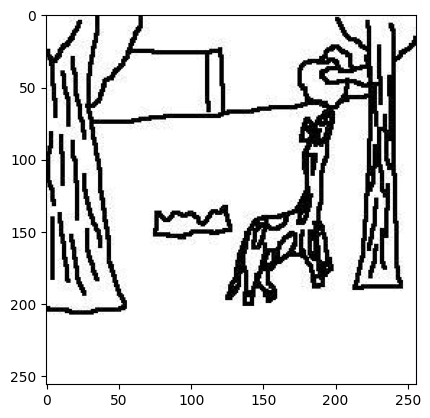

In [ ]:
generate_caption("img9029.jpg") #ok

---------------------Actual---------------------
['startseq a bird is sitting on a tree branch endseq']
---------------------Predicted (Greedy)---------------------
startseq a bird sitting on the branch endseq
---------------------Predicted (Beam Search)---------------------
startseq a bird sitting on a tree branch endseq


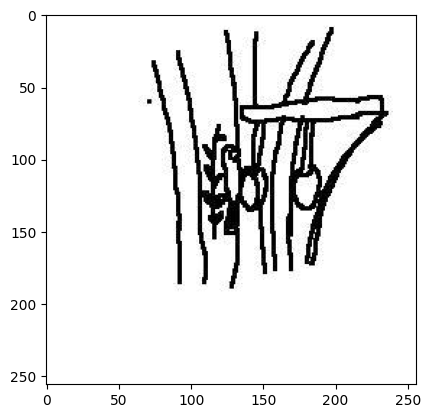

In [ ]:
generate_caption("img9817.jpg") #ok

---------------------Actual---------------------
['startseq a clock tower on a building endseq']
---------------------Predicted (Greedy)---------------------
startseq a clock tower on the building endseq
---------------------Predicted (Beam Search)---------------------
startseq a clock tower on the building endseq endseq


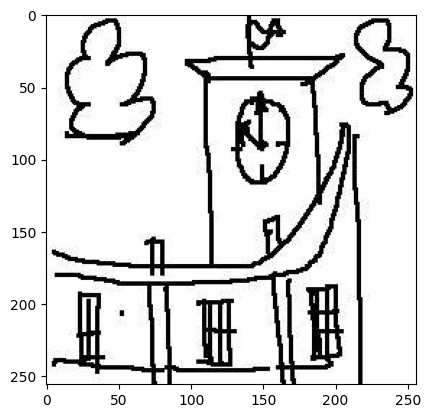

In [ ]:
generate_caption("img8774.jpg") #ok

---------------------Actual---------------------
['startseq a person is flying kite endseq']
---------------------Predicted (Greedy)---------------------
startseq a person is flying a kite endseq
---------------------Predicted (Beam Search)---------------------
startseq a person is flying a kite endseq


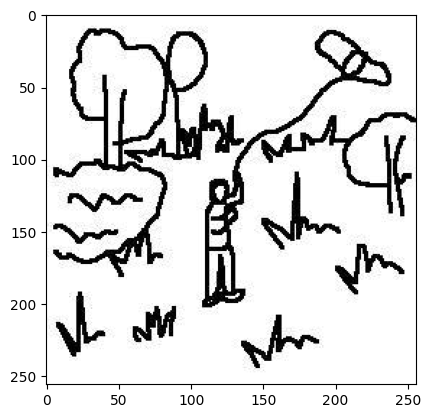

In [ ]:
generate_caption("img9865.jpg") #ok

---------------------Actual---------------------
['startseq guy are flying kite in the sky endseq']
---------------------Predicted (Greedy)---------------------
startseq a man is playing with a flying disc endseq
---------------------Predicted (Beam Search)---------------------
startseq a man holding a kite endseq endseq


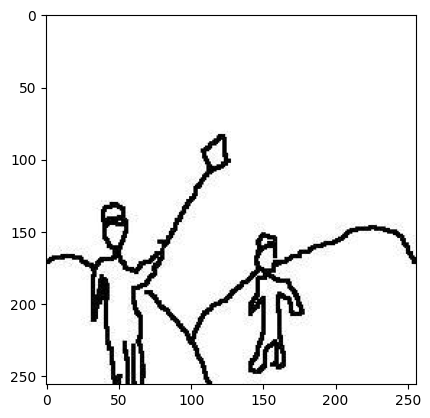

In [ ]:
generate_caption("img9900.jpg") #beam

---------------------Actual---------------------
['startseq an aeroplane flying through the sky endseq']
---------------------Predicted (Greedy)---------------------
startseq a man is flying a kite endseq
---------------------Predicted (Beam Search)---------------------
startseq an areoplane is flying in the sky endseq


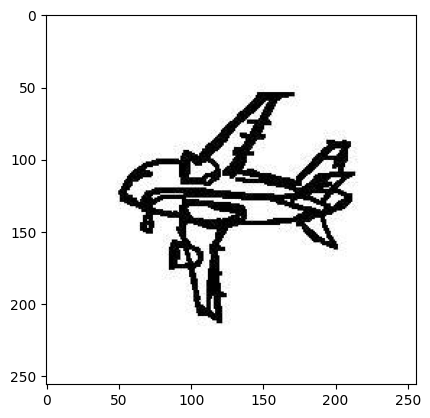

In [ ]:
generate_caption("img9845.jpg") #beam

---------------------Actual---------------------
['startseq an open picnic space where a person is flying a kite endseq']
---------------------Predicted (Greedy)---------------------
startseq a man is playing with a flying disc endseq
---------------------Predicted (Beam Search)---------------------
startseq a man is flying a kite endseq


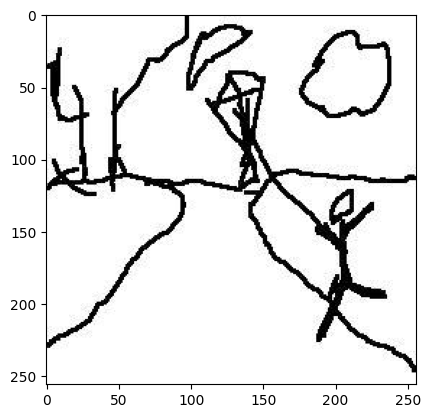

In [ ]:
generate_caption("img8050.jpg") #beam

---------------------Actual---------------------
['startseq bird sitting on a stick endseq']
---------------------Predicted (Greedy)---------------------
startseq a man is sitting on a horse endseq
---------------------Predicted (Beam Search)---------------------
startseq a bird sitting on a tree branch endseq


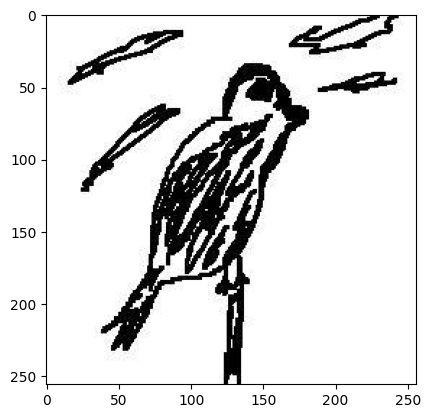

In [ ]:
generate_caption("img8049.jpg") #beam

---------------------Actual---------------------
['startseq giraffe in savana endseq']
---------------------Predicted (Greedy)---------------------
startseq a man is playing with a flying disc endseq
---------------------Predicted (Beam Search)---------------------
startseq a giraffe in a forest endseq


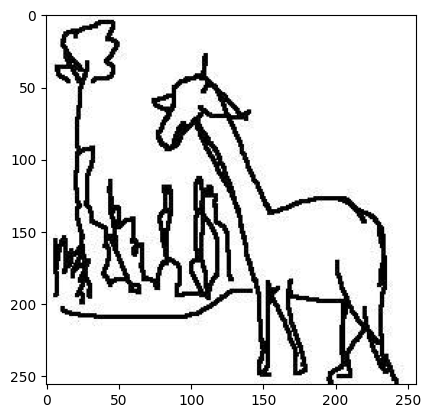

In [ ]:
generate_caption("img9028.jpg") #beam

---------------------Actual---------------------
['startseq bird on branch of fruit tree endseq']
---------------------Predicted (Greedy)---------------------
startseq a man is flying a kite endseq
---------------------Predicted (Beam Search)---------------------
startseq a bird is flying in the sky endseq


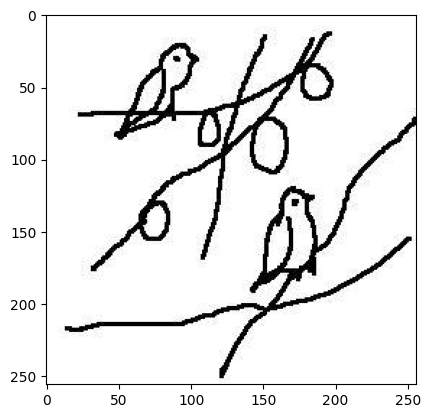

In [ ]:
generate_caption("img9172.jpg") #beam?

---------------------Actual---------------------
['startseq a stop sign board on a pole endseq']
---------------------Predicted (Greedy)---------------------
startseq a stop sign board on the pole endseq
---------------------Predicted (Beam Search)---------------------
startseq sign board on the pole endseq


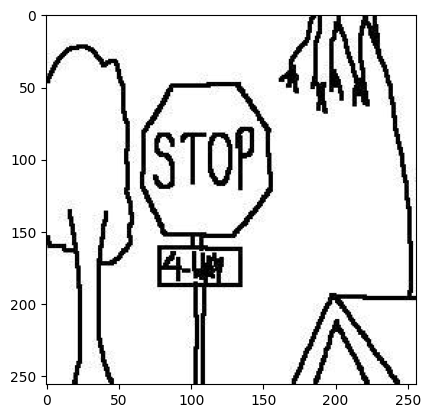

In [ ]:
generate_caption("img9742.jpg") #greedy

---------------------Actual---------------------
['startseq a zebra eating grass in in a jungle endseq']
---------------------Predicted (Greedy)---------------------
startseq a zebra is eating grass endseq
---------------------Predicted (Beam Search)---------------------
startseq a zebra in the forest endseq


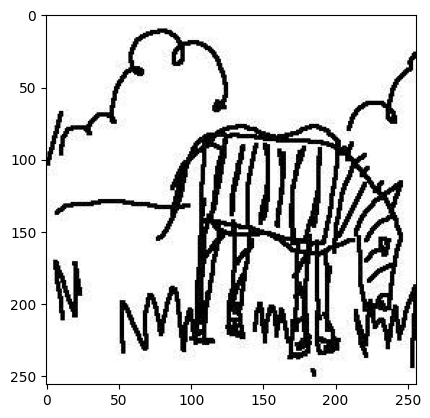

In [ ]:
generate_caption("img9206.jpg") #greedy

---------------------Actual---------------------
['startseq stop sign in w wood endseq']
---------------------Predicted (Greedy)---------------------
startseq a stop sign board on the pole endseq
---------------------Predicted (Beam Search)---------------------
startseq a sign board on a pole endseq


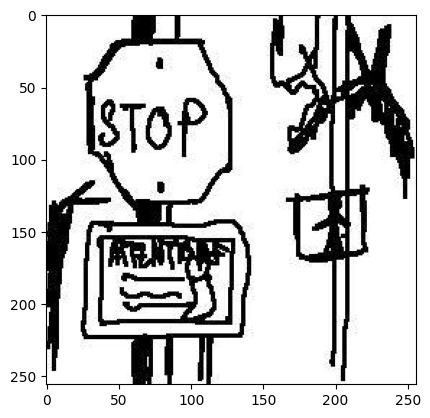

In [ ]:
generate_caption("img8449.jpg") #greedy

---------------------Actual---------------------
['startseq two giraffe grazing endseq']
---------------------Predicted (Greedy)---------------------
startseq a giraffe in a forest endseq
---------------------Predicted (Beam Search)---------------------
startseq a giraffe in a forest endseq


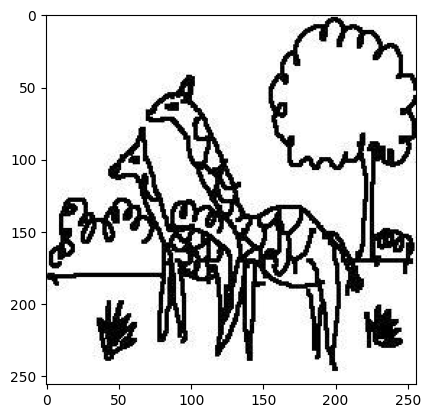

In [ ]:
generate_caption("img8008.jpg") #ok?

---------------------Actual---------------------
['startseq a kid on a skate board endseq']
---------------------Predicted (Greedy)---------------------
startseq a man is playing with a flying disc endseq
---------------------Predicted (Beam Search)---------------------
startseq a boy is playing with a flying disc endseq


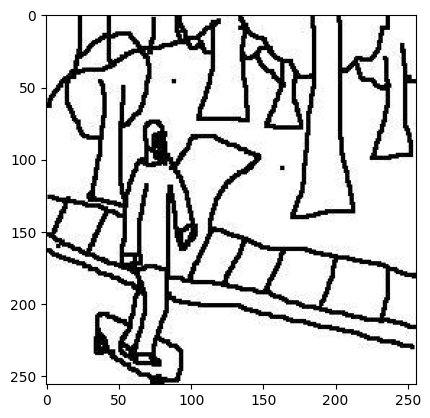

In [ ]:
generate_caption("img9994.jpg") #NO

---------------------Actual---------------------
['startseq two sheep are on the grass endseq']
---------------------Predicted (Greedy)---------------------
startseq a dog is playing with a ring endseq
---------------------Predicted (Beam Search)---------------------
startseq a dog is playing with a ring endseq


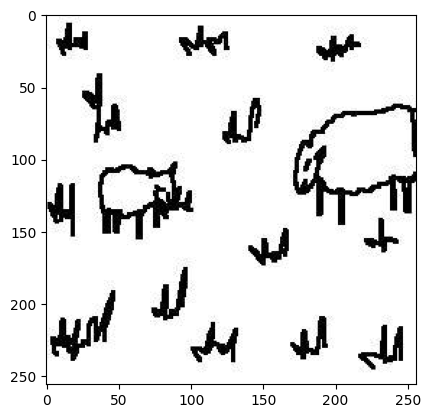

In [ ]:
generate_caption("img8849.jpg") #NO

---------------------Actual---------------------
['startseq sheep are grazing on the grass field endseq']
---------------------Predicted (Greedy)---------------------
startseq a man is playing with a flying disc endseq
---------------------Predicted (Beam Search)---------------------
startseq a person is flying a kite endseq


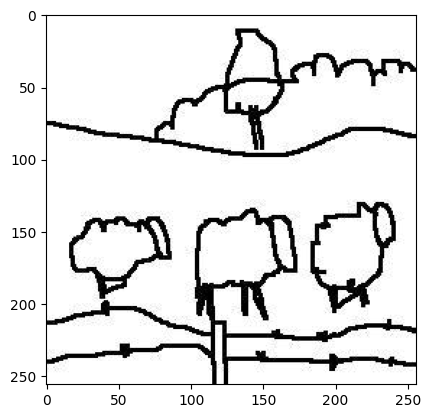

In [ ]:
generate_caption("img9199.jpg") #NO

---------------------Actual---------------------
['startseq a man performing stunt on skate board endseq']
---------------------Predicted (Greedy)---------------------
startseq a man is playing with a flying disc endseq
---------------------Predicted (Beam Search)---------------------
startseq a man holding a kite endseq endseq


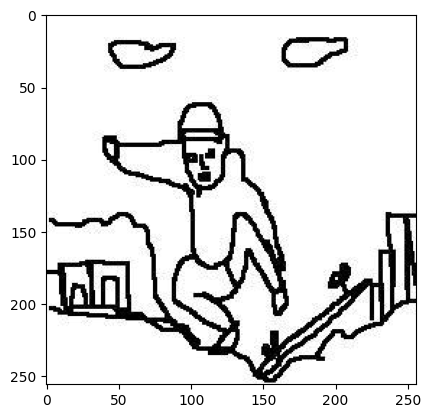

In [ ]:
generate_caption("img9051.jpg") #NO

---------------------Actual---------------------
['startseq a person is skating on a skate board endseq']
---------------------Predicted (Greedy)---------------------
startseq a man is playing with a flying disc endseq
---------------------Predicted (Beam Search)---------------------
startseq a person is flying a kite endseq


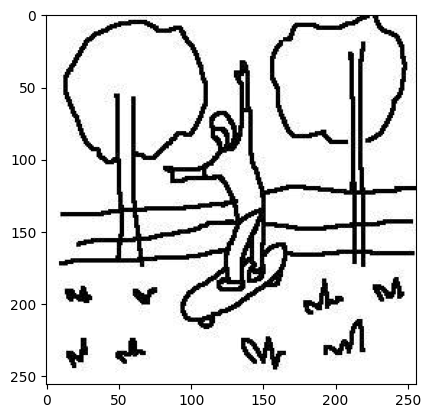

In [ ]:
generate_caption("img9950.jpg") #NO